Mounted at /content/gdrive


Text(0.5, 0, 'Strain')

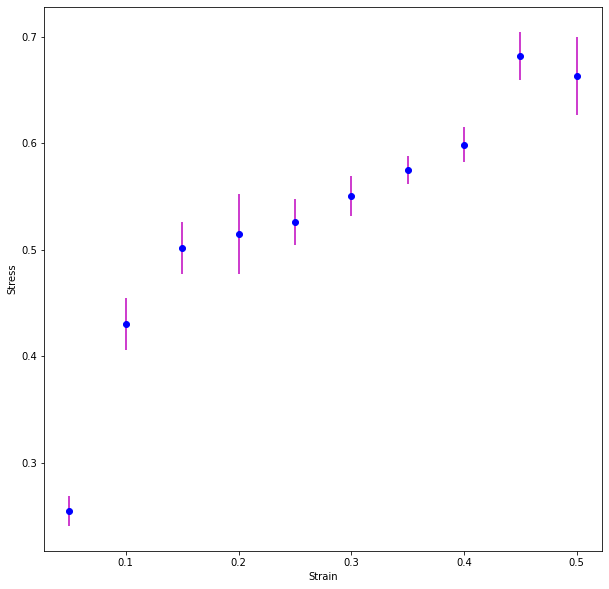

In [3]:
# Display Data
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

# Read the csv file using pandas
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/MDM project/MData.csv')

# Convert the dataframe to a 3D numpy array
array_3d = np.array([df.values.tolist()])
strain = array_3d[0,:,0]
stress = array_3d[0,:,1]
sd = array_3d[0,:,2]

import matplotlib.pyplot as plt
#Plot Strain-Stress Scatter Graph.
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m')
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [4]:
from pylab import * 
import scipy.optimize

def uniaxial_stress(model, trueStrainVec, params):
 """Compressible uniaxial loading. Returns true stress. 
 N: "ture" means add a exp() term on the strain.
 N: model() calls the hyperelastic model, defined below."""
 stress = zeros(len(trueStrainVec))
 for i in range(len(trueStrainVec)):
  lam1 = 1+trueStrainVec[i] #N: convert strain to stretch
  #print(lam1)
  x0 = 1/sqrt(lam1)
  #print(x0)

  calcS22Abs = lambda x: abs( model(lam1,x,x,params)[1,1] )
  #N:The calcS22Abs function is a lambda function that takes 
  #one argument x and returns the absolute value of 
  #the element S22 of the stress tensor, computed by the 
  #model function for a given stretch tensor [lam1,x,x] and params.

  #N:[1,1] is used to access the element in the second row 
  #and second column of the stress tensor (S22)

  # search for transverse stretch that gives S22=0
  lam2 = scipy.optimize.fmin(calcS22Abs, x0,
                 xtol=1e-9, ftol=1e-9, disp=False)
  #N: it uses "fmin" to find the unkown two strains, starting
  #the loop with J=1 (x0=1/sqrt(lam1)),instead of defining a 
  #new variable J.

  stress[i] = model(lam1,lam2,lam2, params)[0,0]
  #N:stores the element S11 in the stress array at 
  #the current strain index i

 return stress
 
def NH_3D(stretch1,stretch2,stretch3,param):
 """Neo-Hookean. 3D loading specified by stretches.
 param[0]=mu, param[1]=kappa"""
 stretch2 = stretch2[0]
 stretch3 = stretch3[0]
 F = array([ [stretch1,0,0],[0,stretch2,0],[0,0,stretch3] ])
 J = det(F)
 Fstar = J**(-1/3) * F
 bstar = dot(Fstar, Fstar.T)
 dev_bstar = bstar - trace(bstar)/3 * eye(3)
 return param[0]/J * dev_bstar + param[1]*(J-1) * eye(3)

In [11]:
# Define Error Esitimation
def percent_error(data, estimated):
  error = 0
  for i in range(len(data)):
    error+=sqrt((data[i]-estimated[i])**2)
  return error/sum(data)

[1.29519994 0.52222714]


Text(0.5, 0, 'Strain')

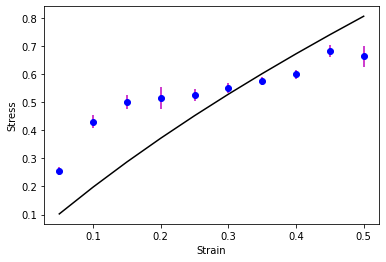

In [6]:
# Determine initial guess by least square root
from scipy.optimize import curve_fit  

def neo_hookean_stress(strain, *params):
   stress = uniaxial_stress(NH_3D, strain, params)
   return stress
p0 = 1., 1.,
params_opt, params_cov = curve_fit(neo_hookean_stress, strain, stress, p0)
#The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. 
print(params_opt)
initial_values = params_opt

#Plot initial guess with least square root method  
stress_initial_guess = uniaxial_stress(NH_3D, strain, initial_values) 
#mu=param[0],k=mu=param[1]

# Fit the data with deterministic model
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m')
ax1.plot(strain, stress_initial_guess, 'k')
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [12]:
percent_error(stress,stress_initial_guess)

0.21489705022698066

In [76]:
# Display the covariance matrix
print(params_cov)

[[ 28.55260286 -14.20962826]
 [-14.20962826   7.08222672]]


**Statistic Model** 

Note we are comparing log(likelihood) here to determine each accceptance each iteration, while Hussein's code uses posterior (prior distibution*likelihood).

In [13]:
def likelihood(param, strain, stress, sd):
    stress_e = uniaxial_stress(NH_3D, strain, param)
    l=-np.log(sd * np.sqrt(2* np.pi))-((stress-stress_e)**2) / (2*sd**2)
    log_likelihood = np.sum(l)
    #print(l)
    return log_likelihood

The prior distribution for the model parameters is simply the normal distribution we used to generate the values of E. 

N: The proposal_sd defines the "transition model" between current guess and new guess.

We can then define the MCMC algorithm using the Metropolis-Hastings algorithm:

In [33]:
def metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iterations, n_params))
    current_values = initial_values
    accepted = np.zeros(n_iterations)
    rejected = np.zeros(n_iterations)
    log_likelihood = np.zeros(n_iterations)
    for i in range(n_iterations):
        # Propose new values
        proposal = current_values + np.random.normal(0, proposal_sds, n_params)
        # Calculate the acceptance ratio
        ratio = np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd))
        #print(ratio)
        acceptance_ratio = min(1, ratio)
        log_likelihood[i] = likelihood(proposal, strain, stress, sd)
        # Decide whether to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_values = proposal
            accepted[i] = 1
        else:
            rejected[i] = 1
        samples[i] = current_values
    return samples, accepted, rejected, log_likelihood

In [75]:
## Section 2; Least Square + MCMC
n_iterations = 5000
proposal_sds = [0.1, 0.1]

# Run MCMC algorithm
samples1, accepted1, rejected1, log_likelihood1 = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

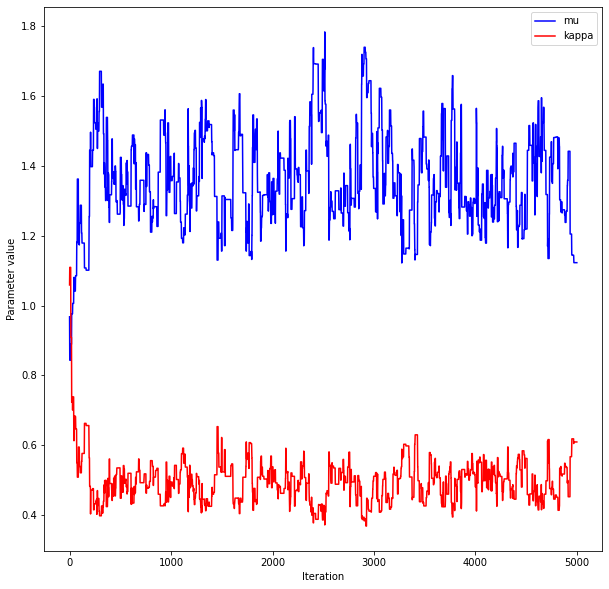

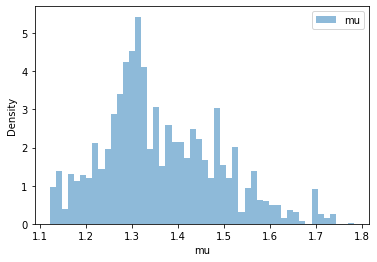

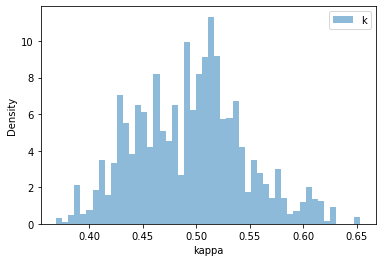

Mean of mu: 1.362835409415805
Median of mu: 1.3349780086972984
Mean of k: 0.4945030591413209
Median of k: 0.4969762841949277
5.0% Confidence interval for mu: [1.32623931 1.34549872]
5.0% Confidence interval for k: [0.49339669 0.50055351]
[1.362835409415805, 0.4945030591413209]
0.21508573434188044
[1.3349780086972984, 0.4969762841949277]
0.2136768993545375
[[ 0.01814043 -0.007953  ]
 [-0.007953    0.00437482]]
[1.36948985 0.48350706]
The Maxmimum Log Likelihood is -150.53
0.21374647956109036


In [78]:
# Evaluation 1: MCMC Process Plot (Determine proper burn-in period)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(samples1[:, 0],"b-", label="mu")
ax.plot(samples1[:, 1],"r-",label="kappa")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value")
ax.legend()
plt.show()

# Evaluation 2/3: Select Mean and Median for conparasion
# burnin
to_show = round(0.1*n_iterations)
burnin = to_show
samples_burned_in = samples1[burnin:]

# Histogram
plt.figure()
plt.hist(samples_burned_in[:, 0], bins=50, density=True, alpha=0.5, label="mu")
plt.xlabel("mu")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 1], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("kappa")
plt.ylabel("Density")
plt.legend()
plt.show()

# Select mean/median
mean_mu = np.mean(samples_burned_in[:, 0])
median_mu = np.median(samples_burned_in[:, 0])

mean_k = np.mean(samples_burned_in[:, 1])
median_k = np.median(samples_burned_in[:, 1])

print("Mean of mu:", mean_mu)
print("Median of mu:", median_mu)
print("Mean of k:", mean_k)
print("Median of k:", median_k)

# Confidance Interval
confidence_level = 0.05
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

CI_C1 = np.percentile(samples_burned_in[:, 0], [lower_percentile * 100, upper_percentile * 100])
CI_D1 = np.percentile(samples_burned_in[:, 1], [lower_percentile * 100, upper_percentile * 100])

print(f"{confidence_level * 100}% Confidence interval for mu: {CI_C1}")
print(f"{confidence_level * 100}% Confidence interval for k: {CI_D1}")
params_mean = [mean_mu, mean_k]
print(params_mean)
stress_guess = uniaxial_stress(NH_3D, strain, params_mean)
print(percent_error(stress, stress_guess))

params_median = [median_mu, median_k]
print(params_median)
stress_guess = uniaxial_stress(NH_3D, strain, params_median)
print(percent_error(stress, stress_guess))

# Evaluation 4: Covariance Metrix
#N: From the MCMC process plot, we already know mu and kappa are negatively correlated.
# Generate two sets of random data
accepted_samples = samples1[accepted1==1][:,:]
x = accepted_samples[:,0]
y = accepted_samples[:,1]
# Calculate the covariance matrix
covariance_matrix = np.cov(x, y)
print(covariance_matrix)

# Evaluation 5: MLE (max. likelihood estimated)
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]
MLE_point1 = estimate_map_point(samples1, log_likelihood1, burn=to_show)
print(MLE_point1)
#print("The MLE is {:.2f} GPa".format(MLE_point))
print("The Maxmimum Log Likelihood is {:.2f}".format(max(log_likelihood1)))

stress_guess = uniaxial_stress(NH_3D, strain, MLE_point1)
print(percent_error(stress, stress_guess))

In [79]:
#shape(accepted_samples)

In [46]:
#shape(log_likelihood1)
#print(log_likelihood1)

In [74]:
## Section 3; Run MCMC without the pre-defined initial guess
initial_values = 1.,1.,
n_iterations = 5000
proposal_sds = [0.1, 0.1]

# Run MCMC algorithm
samples, accepted, rejected, log_likelihood = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

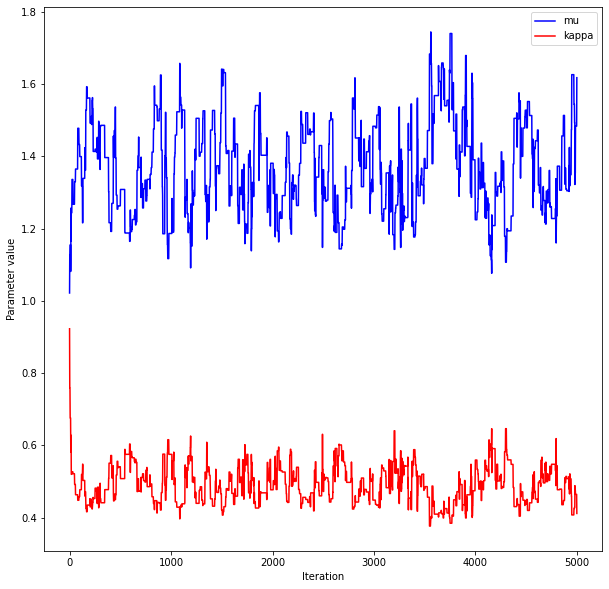

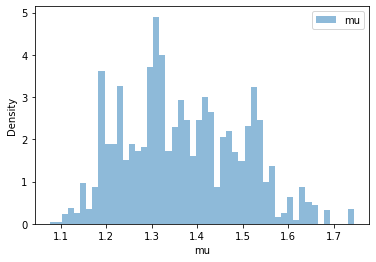

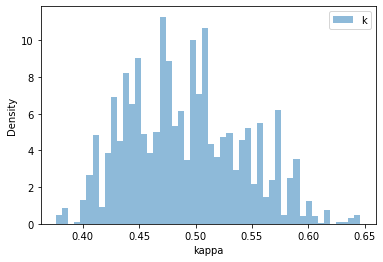

Mean of mu: 1.3693578456165776
Median of mu: 1.357828513056961
Mean of k: 0.49122115040063363
Median of k: 0.4861593802205453
5.0% Confidence interval for mu: [1.34814425 1.36736538]
5.0% Confidence interval for k: [0.48267989 0.4915843 ]
[1.3693578456165776, 0.49122115040063363]
0.21497912552553253
[1.357828513056961, 0.4861593802205453]
0.21343336491674392
[[ 0.01642655 -0.00659364]
 [-0.00659364  0.00312436]]
[1.36736538 0.48563297]
The Maxmimum Log Likelihood is -150.53
0.21395496228078162


In [80]:
# Evaluation 1: MCMC Process Plot (Determine proper burn-in period)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(samples[:, 0],"b-", label="mu")
ax.plot(samples[:, 1],"r-",label="kappa")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value")
ax.legend()
plt.show()

# Evaluation 2/3: Select Mean and Median for conparasion
# burnin
burnin = to_show
samples_burned_in = samples[burnin:]

# Histogram
plt.figure()
plt.hist(samples_burned_in[:, 0], bins=50, density=True, alpha=0.5, label="mu")
plt.xlabel("mu")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 1], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("kappa")
plt.ylabel("Density")
plt.legend()
plt.show()

# Select mean/median
mean_mu = np.mean(samples_burned_in[:, 0])
median_mu = np.median(samples_burned_in[:, 0])

mean_k = np.mean(samples_burned_in[:, 1])
median_k = np.median(samples_burned_in[:, 1])

print("Mean of mu:", mean_mu)
print("Median of mu:", median_mu)
print("Mean of k:", mean_k)
print("Median of k:", median_k)

# Confidance Interval
confidence_level = 0.05
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

CI_C1 = np.percentile(samples_burned_in[:, 0], [lower_percentile * 100, upper_percentile * 100])
CI_D1 = np.percentile(samples_burned_in[:, 1], [lower_percentile * 100, upper_percentile * 100])

print(f"{confidence_level * 100}% Confidence interval for mu: {CI_C1}")
print(f"{confidence_level * 100}% Confidence interval for k: {CI_D1}")
params_mean = [mean_mu, mean_k]
print(params_mean)
stress_guess = uniaxial_stress(NH_3D, strain, params_mean)
print(percent_error(stress, stress_guess))

params_median = [median_mu, median_k]
print(params_median)
stress_guess = uniaxial_stress(NH_3D, strain, params_median)
print(percent_error(stress, stress_guess))

# Evaluation 4: Covariance Metrix
#N: From the MCMC process plot, we already know mu and kappa are negatively correlated.
# Generate two sets of random data
accepted_samples = samples[accepted==1][:,:]
x = accepted_samples[:,0]
y = accepted_samples[:,1]
# Calculate the covariance matrix
covariance_matrix = np.cov(x, y)
print(covariance_matrix)

# Evaluation 5: MLE (max. likelihood estimated)
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]
MLE_point = estimate_map_point(samples, log_likelihood, burn=to_show)
print(MLE_point)
#print("The MLE is {:.2f} GPa".format(MLE_point))
print("The Maxmimum Log Likelihood is {:.2f}".format(max(log_likelihood)))

stress_guess = uniaxial_stress(NH_3D, strain, MLE_point)
print(percent_error(stress, stress_guess))

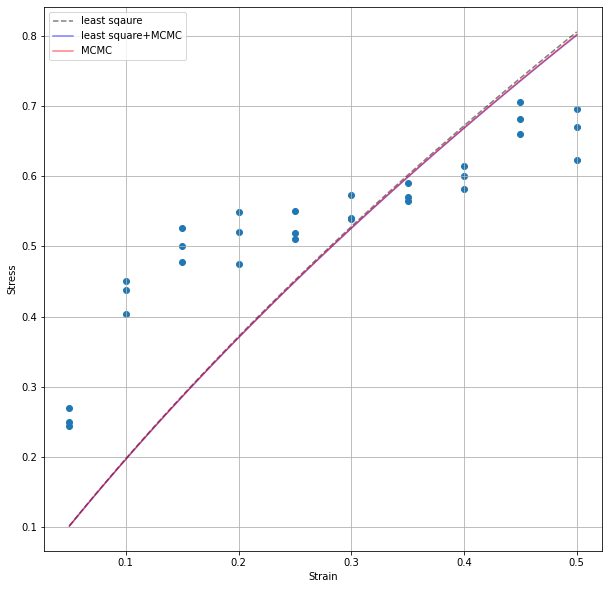

In [85]:
stress1=np.array([])
stress2=np.array([])
stress3=np.array([])
strain=np.array([])
stress1 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress1.csv",
                 delimiter=",", dtype=float)
stress2 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress2.csv",
                 delimiter=",", dtype=float)
stress3 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress3.csv",
                 delimiter=",", dtype=float)
strain = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Strain.csv",
                 delimiter=",", dtype=float)
x = np.concatenate((stress1,stress2,stress3), axis=0)
y = np.concatenate((strain,strain,strain), axis=0)
plt.figure(figsize=(10,10))
plt.scatter(y,x)

# plot the model corresponding to the mean of the posterior distribution
x_true = np.linspace(0.05, 0.5, 101)
y_s = uniaxial_stress(NH_3D, x_true, params_opt)
y_sMCMC = uniaxial_stress(NH_3D, x_true, MLE_point1) 
y_MCMC = uniaxial_stress(NH_3D, x_true, MLE_point) 
plt.plot(x_true, y_s, "k--",label="least sqaure",alpha=0.5)
plt.plot(x_true, y_sMCMC, "b",label="least square+MCMC",alpha=0.5)
plt.plot(x_true, y_MCMC, "r",label="MCMC",alpha=0.5)

plt.legend()
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.grid()
plt.show()
